# **POS tagging as Sequence Labeling using Recurrent Neural Networks**

### Natural Language Processing

In [ ]:
!pip install gensim==4.0.0

In [2]:
# Importing libraries

import os
import random
from tqdm import tqdm
from urllib import request
from zipfile import ZipFile

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import gensim
import gensim.downloader as gloader

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Input, Dense, TimeDistributed, Dropout

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

### 1. Downloading the corpora and splitting it in training and test sets, structuring a dataframe

In [3]:
file_path = 'data/dependency_treebank.zip'

if 'data' not in os.listdir():
    os.mkdir('data')

# Download and extract the treebank
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
request.urlretrieve(url, file_path)
print('Dataset downloaded!')

with ZipFile(file_path, 'r') as zip_obj:
    zip_obj.extractall('data/')
    print('Dataset extracted!')   

Dataset downloaded!
Dataset extracted!


In [4]:
# Setting random seed for reproducibility
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(42)

The dataset is split into train, validation and test sets structuring a dataframe, while the documents are also split into sentences.
The input of the model for training is encoded in a sequence of pairs <code>(token, pos_tag)</code> and its length is given by the maximum length of a sentence.

In [5]:
data_split = {'train': pd.DataFrame(columns=['sentence', 'pos']),
              'validation': pd.DataFrame(columns=['sentence', 'pos']),
              'test': pd.DataFrame(columns=['sentence', 'pos'])}

for filename in sorted(os.listdir('data/dependency_treebank')):
    with open('data/dependency_treebank/' + filename, 'r') as f:
        # check file number
        file_number = int(filename.split('_')[1][:-3])
        # split into train, val and test set depending on the file numbers
        if file_number <= 100:
            name = 'train'
        elif file_number <= 150:
            name = 'validation'
        else:
            name = 'test'
    
        # read the files and create a pandas dataframe
        df = pd.read_table('data/dependency_treebank/' + filename, delimiter='\t', names=['word','pos'], header=None, usecols=[0,1], skip_blank_lines=False)
        
        # find NaN rows and split on them to generate sentences
        idx = list(df.loc[df.isnull()['word']].index)
        idx.append(len(df))
        prev = 0
        for sep in idx:
            df_sentence = pd.DataFrame({'sentence': [df['word'][prev:sep].to_list()], 
                                        'pos': [df['pos'][prev:sep].to_list()]})
            data_split[name] = pd.concat([data_split[name], df_sentence], ignore_index = True)
            prev = sep + 1

## 2) Exploratory Data Analysis

Exploring sentences and POS tags of the training set

In [6]:
data_split['train']

,sentence,pos
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
...,...,...
1958,"[It, would, be, a, good, match, ,, Mr., Hahn, ...","[PRP, MD, VB, DT, JJ, NN, ,, NNP, NNP, CC, JJ,..."
1959,"[The, resulting, company, would, be, the, larg...","[DT, VBG, NN, MD, VB, DT, JJS, NNS, NN, IN, DT..."
1960,"[But, can, Mr., Hahn, carry, it, off, ?]","[CC, MD, NNP, NNP, VB, PRP, IN, .]"
1961,"[In, this, instance, ,, industry, observers, s...","[IN, DT, NN, ,, NN, NNS, VBP, ,, PRP, VBZ, VBG..."


There is a total of 1963 sentences in the training set. Now, as an example, we check the first complete sentence of the training set, including punctuation.

In [7]:
# Example of a sentence in the training set
print(data_split['train']['sentence'][0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


Data is analyzed to explore features and distribution in the training, validation and test sets. To do so, data is split into sentences and POS tags for all the set splits.

In [8]:
X_train = data_split['train']['sentence']
y_train = data_split['train']['pos']

print('The number of samples in the training set is', len(data_split['train']))

The number of samples in the training set is 1963


In [9]:
X_val = data_split['validation']['sentence']
y_val = data_split['validation']['pos']

print('The number of samples in the validation set is', len(data_split['validation']))

The number of samples in the validation set is 1299


In [10]:
X_test = data_split['test']['sentence']
y_test = data_split['test']['pos']

print('The number of samples in the test set is', len(data_split['test']))

The number of samples in the test set is 652


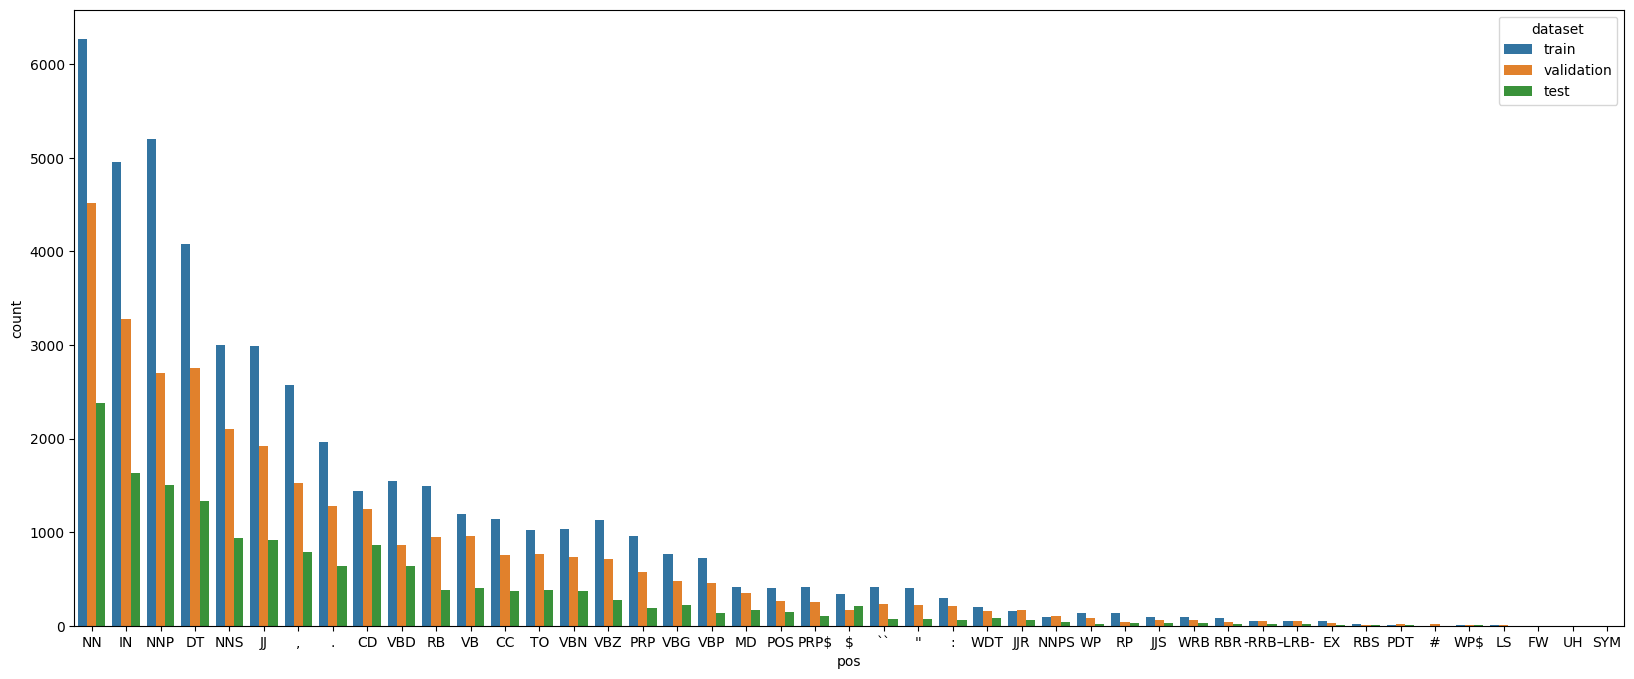

In [11]:
# Plotting classes distribution in train, val and test sets

datasets = ['train', 'validation', 'test']
plot_data = pd.DataFrame(columns=['pos', 'dataset'])

for dataset in datasets:
    df = data_split[dataset]
    pos_values = [item for sublist in df['pos'] for item in sublist]
    dataset_values = [dataset] * len(pos_values)
    plot_data = pd.concat([plot_data, pd.DataFrame({'pos': pos_values, 'dataset': dataset_values})])

plt.figure(figsize=(20, 8))
sns.countplot(x='pos', data=plot_data, hue='dataset',
              order=plot_data['pos'].value_counts().index)

plt.show()

The plot shows how the classes are not evenly distributed in the different sets.

### Embedding the words using GloVe embeddings

Downloading the pre-trained GloVe embeddings using 50 as embedding dimension.

In [12]:
def load_glove(embedding_dimension=50):
    '''
    Loads pre-computed GloVe embeddings using Gensim library.


    :param embedding_dimension: {50, 100, 200, 300}, default: 50
            Dimension of the vectors to load. 
    
    :return emb_model: Gensim model containing the embeddings
    '''
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model

EMBEDDING_DIM = 50
gloves = load_glove(EMBEDDING_DIM)

[==================================================] 100.0% 66.0/66.0MB downloaded


At this point we check the OOV terms which are in the training set but not in the GloVe's vocabulary. 

In [13]:
def check_OOV_terms(vocabulary, word_listing):
    '''
    Checks differences between model vocabulary and dataset specific vocabulary 
    to highlight out-of-vocabulary terms.

    :param vocabulary: all the words in the vocabulary
    :param word_listing: dataset specific vocabulary of words occurring at least once in the dataset

    :return list of OOV terms
    '''
    embedding_vocabulary = set(vocabulary)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

train_vocab = X_train.explode().drop_duplicates().to_list()
oov_terms = check_OOV_terms(gloves.index_to_key, train_vocab)

We process all the data by turning all the words into lowercase.

In [14]:
# Applying lowercase and computing OOVs
X_train_low = X_train.apply(lambda x: [word.lower() for word in x])
train_vocab = X_train_low.explode().to_list()

oov_terms = check_OOV_terms(gloves.index_to_key, train_vocab)
oov_percentage = len(oov_terms)/len(train_vocab) * 100

print(f'Number of OOV terms in the training set: {len(oov_terms)}')

Number of OOV terms in the training set: 359


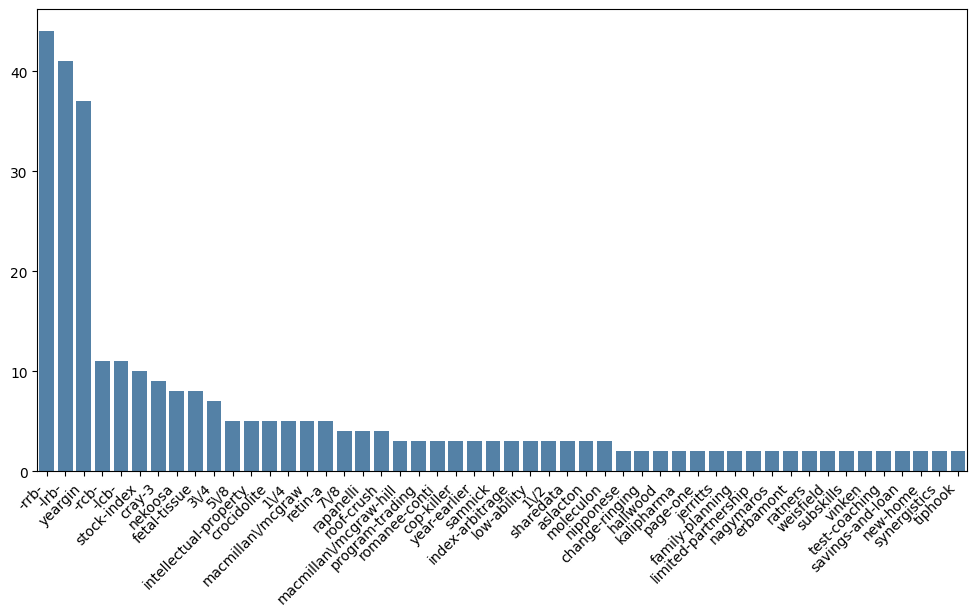

In [15]:
# Plotting the 50 most frequent OOVs
oov_occ = pd.Series([word for sentence in X_train_low for word in sentence if word in oov_terms])
oov_occ = oov_occ.value_counts()[:50]

_, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=oov_occ.index, y=oov_occ.values, color='steelblue', ax=ax)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

What can be observed is that left and right brackets are represented with values like -lrb- and -rrb-. Also, there are floating points numers which instead should be replaced by a placeholder and the double slash character which should be fixed. Hence, some preprocessing is performed.

In [16]:
def preprocess(text):
  '''Preprocesses text using regular expressions
  
  :param text: text to be preprocessed using regular expressions

  :return re_words: preprocessed words
  '''
  re_words = [token.lower() for token in text]
  re_words = ['<float>' if re.match('(\d*\,)?\d+\.\d*', token) else token for token in re_words]
  re_words = [re.sub('(-lrb-)|(-lcb-)', '(', token) for token in re_words]
  re_words = [re.sub('(-rrb-)|(-rcb-)', ')', token) for token in re_words]
  re_words = [re.sub('(\\\/)', '-', token) for token in re_words]
  return re_words

X_train_prepr = X_train.apply(preprocess)

In [17]:
train_vocab = X_train_prepr.explode().drop_duplicates().to_list()
oov_terms = check_OOV_terms(gloves.index_to_key, train_vocab)
oov_percentage = len(oov_terms)/len(train_vocab) * 100
print(f'Number of OOV terms in the training set: {len(oov_terms)} ({oov_percentage:.2f}%)')

Number of OOV terms in the training set: 319 (4.42%)


In [18]:
oov_occ = X_train_prepr.explode()[X_train_prepr.explode().isin(oov_terms)]
oov_occ = oov_occ.value_counts()[:10]

print(f'The most common OOVs in the training set are:\n{oov_occ}')

The most common OOVs in the training set are:
<float>                  212
yeargin                   37
stock-index               10
cray-3                     9
nekoosa                    8
fetal-tissue               8
intellectual-property      5
crocidolite                5
retin-a                    5
macmillan-mcgraw           5
Name: sentence, dtype: int64


### 3) Creation of numeric mappings for sentences and POS tags

A word/token vocabulary is created using the TextTransformer class, which also allows to transform all the sentences in sequences, according to the vocabulary, and to create a numerical mapping for the POS tags.

In [19]:
# Applying preprocessing to validation and test sets
X_val_prepr = X_val.apply(preprocess)
X_test_prepr = X_test.apply(preprocess)

In [20]:
class TextTransformer:
  def __init__(self, initial_vocab=None):
    '''
    Create a vocabulary and transform a set of sentences in a set of sequences and viceversa.
    '''
    self.word_idx = {}
    self.idx_to_word = {}
    self.__idx = 1
    if initial_vocab:
      self.update_vocabulary(initial_vocab)

  def update_vocabulary(self, texts):
    '''
    Create/Update the vocabulary using the list of text sentences in input

    :param texts: list of sentences
    '''
    for text in texts:
      for token in text:
        if token not in self.word_idx:
          self.word_idx[token] = self.__idx
          self.idx_to_word[self.__idx] = token
          self.__idx += 1

  def texts_to_sequences(self, texts):
    '''
    Transform a list of sentences in a list of sequences, according to the current vocabulary

    :param texts: list of sentences
    '''
    sequences = []
    for text in texts:
      sequence = []
      for token in text:
        sequence.append(self.word_idx[token])
      sequences.append(sequence)
    return sequences

  def sequences_to_texts(self, sequences):
    '''
    Transform a list of sequences in a list of sentences, according to the current vocabulary

    :param sequences: list of sequences
    '''
    texts = []
    for seq in sequences:
      text = []
      for idx in seq:
        text.append(self.idx_to_word[idx])
      texts.append(text)
    return texts

In [21]:
# Initializing vocabulary using the GloVe's keys
voc = TextTransformer(initial_vocab=[gloves.key_to_index.keys()])
# Updating vocabulary 
voc.update_vocabulary(X_train_prepr)

In [22]:
# Inizializing POS sequence
pos_seq = TextTransformer()
pos_seq.update_vocabulary(y_train)
pos_seq.update_vocabulary(y_val)
pos_seq.update_vocabulary(y_test)

In [23]:
# Encoding from text sequences to numerical sequences
X_train_encoded = voc.texts_to_sequences(X_train_prepr)
y_train_encoded = pos_seq.texts_to_sequences(y_train)
y_val_encoded = pos_seq.texts_to_sequences(y_val)
y_test_encoded = pos_seq.texts_to_sequences(y_test)

In [24]:
# Number of different POS tags
num_classes = len(pos_seq.word_idx)

Printing an example of processed sentence and its encoding.

In [25]:
print("X: ", X_train_prepr[0])
print("X encoded: ", X_train_encoded[0])

X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']
X encoded:  [5030, 400001, 2, 4979, 83, 168, 2, 44, 1430, 1, 535, 20, 8, 128565, 370, 2344, 1264, 3]


In [26]:
print("Y: ", y_train[0])
print("Y encoded", y_train_encoded[0])

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
Y encoded [1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9, 1, 3, 11]


In [27]:
# POS tags with each encoding
print("\n".join("{}\t{}".format(k, v) for k, v in pos_seq.word_idx.items()))

NNP	1
,	2
CD	3
NNS	4
JJ	5
MD	6
VB	7
DT	8
NN	9
IN	10
.	11
VBZ	12
VBG	13
CC	14
VBD	15
VBN	16
RB	17
TO	18
PRP	19
RBR	20
WDT	21
VBP	22
RP	23
PRP$	24
JJS	25
POS	26
``	27
EX	28
''	29
WP	30
:	31
JJR	32
WRB	33
$	34
NNPS	35
WP$	36
-LRB-	37
-RRB-	38
PDT	39
RBS	40
FW	41
UH	42
SYM	43
LS	44
#	45


Then, the **embedding matrix** is created, using all the pre-computed vectors which are in the GloVe embeddings. As for the other OOVs in the dataset, they are assigned random embeddings generated in a random way, selected from a uniform distribution.

The initial embedding matrix is built using the ```build_embedding_matrix``` function, based only on the vocabulary that includes the GloVe's keys and the OOVs of the training set. Subsequently the embedding matrix is updated by calling the ```update_embedding_matrix``` function on both the validation and test updated dictionaries.

In [28]:
class EmbeddingMatrix():
    def __init__(self):
        self.vocab_comp = {}
    
    def build_embedding_matrix(self, embeddings, embedding_size, word_to_idx):
        '''
        Build embedding matrix that will be used for the embedding layer. 

        :param embeddings: GloVe embeddings of the given size
        :param embedding_size: size of the embedding vectors to be generated (same as GloVe embeddings size)
        :param word_to_idx: mapping between each word in the vocabulary and a number (dict)
        

        :return matrix containing the embedding of every word in our vocabulary
        '''
                
        vocab_size = len(word_to_idx.keys()) + 1
        embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)
        
        for word, idx in word_to_idx.items():
            try:
                embedding_vector = embeddings[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_size)
                    
            embedding_matrix[idx] = embedding_vector
        return embedding_matrix
    
    def update_embedding_matrix(self, embedding_matrix, embeddings, word_to_idx):
        '''
        Update embedding_matrix with the new OOV words present on word_to_idx 

        :param embedding_matrix: initial embedding matrix
        :param embeddings: GloVe embeddings of the given size
        :param word_to_idx: Mapping between each word in our vocabulary and a number (dict)
        
        :return new_embedding_matrix: updated embedding matrix
        '''
        new_embeddings = []
        embedding_size = embedding_matrix.shape[1]
        for word, idx in list(word_to_idx.items())[embedding_matrix.shape[0]:]:
            try:
                embedding_vector = embeddings[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_size)
            new_embeddings.append(embedding_vector)
        if len(new_embeddings) == 0:
            new_embedding_matrix = embedding_matrix
        else:
            new_embedding_matrix = np.concatenate((embedding_matrix, np.array(new_embeddings)), axis=0)
        return new_embedding_matrix        

In [29]:
print(len(voc.word_idx.keys()))
# Creation of the embedding matrix
emb = EmbeddingMatrix()
embeddings = emb.build_embedding_matrix(gloves, 50, voc.word_idx)

400319


In [30]:
# Updating vocabulary on val set
voc.update_vocabulary(X_val_prepr)
X_val_encoded = voc.texts_to_sequences(X_val_prepr)
print(len(voc.word_idx.keys()))
embeddings = emb.update_embedding_matrix(embeddings, gloves, voc.word_idx)

# Updating vocabulary on test set
voc.update_vocabulary(X_test_prepr)
X_test_encoded = voc.texts_to_sequences(X_test_prepr)
print(len(voc.word_idx.keys()))

# Updating embedding matrix after vocabulary update
embeddings = emb.update_embedding_matrix(embeddings, gloves, voc.word_idx)

400479
400575


**Padding sequences**: the sentences and the classes previously encoded are padded, since we need each sentence to have the same length in each batch during training.

In [31]:
max_length_train = max([len(x) for x in X_train_encoded])
max_length_val = max([len(x) for x in X_val_encoded])
max_length_test = max([len(x) for x in X_test_encoded])

# Pad the sequences to the corresponding max lengths
X_train_pad = pad_sequences(X_train_encoded, maxlen=max_length_train, padding='post')
X_val_pad = pad_sequences(X_val_encoded, maxlen=max_length_val, padding='post')
X_test_pad = pad_sequences(X_test_encoded, maxlen=max_length_test, padding='post')

y_train_pad = pad_sequences(y_train_encoded, maxlen=max_length_train, padding='post')
y_val_pad = pad_sequences(y_val_encoded, maxlen=max_length_val, padding='post')
y_test_pad = pad_sequences(y_test_encoded, maxlen=max_length_test, padding='post')

In [32]:
# One-hot encoding applied on the padded classes
y_train_hot = to_categorical(y_train_pad, num_classes=num_classes+1)
y_val_hot = to_categorical(y_val_pad, num_classes=num_classes+1)
y_test_hot = to_categorical(y_test_pad, num_classes=num_classes+1)

Defining the POS tags that do not contribute to the F1 score evaluation to be filtered out


In [33]:
punct_pos_filters = [',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM', 'LS']
pos_filters_enc = pos_seq.texts_to_sequences([punct_pos_filters])[0]
pos_filters_enc.append(0)

In [34]:
def get_filtered_predictions(y_true_hot, y_pred_hot, filters):
    '''
    Filter out the predictions for the padding class and for 
    punctuation/symbols that do not contribute to the final evaluation.

    :param y_true_hot: ground truth one hot encoded values
    :param y_pred_hot: predicted values by our model
    :param filters: numeric encoding of the classes to filter out
    
    :return: filtered ground truth values and filtered predicted values
    '''
    # flatten the arrays of one-hot encoded values
    y_true_flat = np.argmax(y_true_hot, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred_hot, axis=-1).flatten()
    
    # boolean mask to filter out classes 
    pos_mask = np.array([y_true_flat == sym for sym in filters])
    pos_mask = ~np.sum(pos_mask, axis = 0, dtype='bool')

    # filtered ground truth and predicted values
    return y_true_flat[pos_mask], y_pred_flat[pos_mask]

Defining the parameters used during the training phase of the models

In [35]:
BATCH_SIZE = 16
N_EPOCHS = 50

models = {}
histories = {}

In [36]:
# early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

## 4) Model definition

### Baseline model (Bi-LSTM + FC)

In [37]:
inputs = Input(shape=(None,), dtype="int32")
x = Embedding(
      input_dim=embeddings.shape[0],
      output_dim=embeddings.shape[1],
      mask_zero=True, 
      weights=[embeddings], 
      trainable=False)(inputs)

rnn = LSTM(units=100, return_sequences=True)
x = Bidirectional(rnn)(x)
x = TimeDistributed(Dense(num_classes+1, activation='softmax'))(x)

models['BiLSTM'] = Model(inputs, x, name='BiLSTM')
models['BiLSTM'].summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20028750  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 46)         9246      
 ibuted)                                                         
                                                                 
Total params: 20,158,796
Trainable params: 130,046
Non-trainable params: 20,028,750
_________________________________________________________________


In [38]:
models['BiLSTM'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['BiLSTM'] = models['BiLSTM'].fit(
                   x=X_train_pad, 
                   y=y_train_hot, 
                   batch_size=BATCH_SIZE, 
                   epochs=N_EPOCHS, 
                   validation_data=(X_val_pad, y_val_hot),
                   callbacks=[early_stopping]
                   )

Epoch 1/50
123/123 [==============================] - 18s 40ms/step - loss: 2.3050 - accuracy: 0.3999 - val_loss: 1.5138 - val_accuracy: 0.5990
Epoch 2/50
123/123 [==============================] - 2s 20ms/step - loss: 1.1689 - accuracy: 0.6936 - val_loss: 1.0165 - val_accuracy: 0.7235
Epoch 3/50
123/123 [==============================] - 3s 26ms/step - loss: 0.8612 - accuracy: 0.7657 - val_loss: 0.8387 - val_accuracy: 0.7644
Epoch 4/50
123/123 [==============================] - 2s 20ms/step - loss: 0.7239 - accuracy: 0.7985 - val_loss: 0.7354 - val_accuracy: 0.7906
Epoch 5/50
123/123 [==============================] - 2s 18ms/step - loss: 0.6364 - accuracy: 0.8205 - val_loss: 0.6733 - val_accuracy: 0.8073
Epoch 6/50
123/123 [==============================] - 2s 18ms/step - loss: 0.5730 - accuracy: 0.8375 - val_loss: 0.6267 - val_accuracy: 0.8165
Epoch 7/50
123/123 [==============================] - 2s 20ms/step - loss: 0.5240 - accuracy: 0.8518 - val_loss: 0.5945 - val_accuracy: 0.823

### Baseline model with an additional LSTM layer (BiLSTMx2 + FC)

In [39]:
inputs = Input(shape=(None,), dtype="int32")
x = Embedding(
      input_dim=embeddings.shape[0], 
      output_dim=embeddings.shape[1],
      mask_zero=True, 
      weights=[embeddings], 
      trainable=False)(inputs)

rnn = LSTM(units=100, return_sequences=True)
x = Bidirectional(rnn)(x)
x = LSTM(units=100, return_sequences=True)(x)
x = TimeDistributed(Dense(num_classes+1, activation='softmax'))(x)

models['BiLSTM2x'] = Model(inputs, x, name='BiLSTM2x')
models['BiLSTM2x'].summary()

Model: "BiLSTM2x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 time_distributed_1 (TimeDis  (None, None, 46)         4646      
 tributed)                                                       
                                                                 
Total params: 20,274,596
Trainable params: 245,846
Non-tra

In [40]:
models['BiLSTM2x'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['BiLSTM2x'] = models['BiLSTM2x'].fit(x=X_train_pad, 
                              y=y_train_hot, 
                              batch_size=BATCH_SIZE, 
                              epochs=N_EPOCHS, 
                              validation_data=(X_val_pad, y_val_hot),
                              callbacks=[early_stopping]
                              )

Epoch 1/50
123/123 [==============================] - 20s 63ms/step - loss: 2.5786 - accuracy: 0.3023 - val_loss: 1.8414 - val_accuracy: 0.5036
Epoch 2/50
123/123 [==============================] - 3s 24ms/step - loss: 1.4074 - accuracy: 0.6192 - val_loss: 1.1880 - val_accuracy: 0.6818
Epoch 3/50
123/123 [==============================] - 3s 25ms/step - loss: 0.9833 - accuracy: 0.7382 - val_loss: 0.9208 - val_accuracy: 0.7475
Epoch 4/50
123/123 [==============================] - 6s 45ms/step - loss: 0.7859 - accuracy: 0.7849 - val_loss: 0.7759 - val_accuracy: 0.7819
Epoch 5/50
123/123 [==============================] - 3s 26ms/step - loss: 0.6619 - accuracy: 0.8185 - val_loss: 0.6819 - val_accuracy: 0.8073
Epoch 6/50
123/123 [==============================] - 3s 24ms/step - loss: 0.5717 - accuracy: 0.8427 - val_loss: 0.6142 - val_accuracy: 0.8228
Epoch 7/50
123/123 [==============================] - 4s 30ms/step - loss: 0.5072 - accuracy: 0.8588 - val_loss: 0.5690 - val_accuracy: 0.835

### Baseline model with GRU layer (BiGRU + FC)

In [41]:
inputs = Input(shape=(None,), dtype="int32")
x = Embedding(
      input_dim=embeddings.shape[0], 
      output_dim=embeddings.shape[1],
      mask_zero=True, 
      weights=[embeddings], 
      trainable=False)(inputs)

rnn = GRU(units=100, return_sequences=True)
x = Bidirectional(rnn)(x)
x = TimeDistributed(Dense(num_classes+1, activation='softmax'))(x)

models['BiGRU'] = Model(inputs, x, name='BiGRU')
models['BiGRU'].summary()

Model: "BiGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        91200     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 46)         9246      
 tributed)                                                       
                                                                 
Total params: 20,129,196
Trainable params: 100,446
Non-trainable params: 20,028,750
_________________________________________________________________


In [42]:
models['BiGRU'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['BiGRU'] = models['BiGRU'].fit(x=X_train_pad, 
                              y=y_train_hot, 
                              batch_size=BATCH_SIZE, 
                              epochs=N_EPOCHS, 
                              validation_data=(X_val_pad, y_val_hot),
                              callbacks=[early_stopping]
                              )

Epoch 1/50
123/123 [==============================] - 14s 43ms/step - loss: 1.9954 - accuracy: 0.4991 - val_loss: 1.2120 - val_accuracy: 0.6816
Epoch 2/50
123/123 [==============================] - 3s 21ms/step - loss: 0.9409 - accuracy: 0.7484 - val_loss: 0.8431 - val_accuracy: 0.7672
Epoch 3/50
123/123 [==============================] - 3s 23ms/step - loss: 0.7129 - accuracy: 0.8005 - val_loss: 0.7168 - val_accuracy: 0.7938
Epoch 4/50
123/123 [==============================] - 3s 24ms/step - loss: 0.6048 - accuracy: 0.8281 - val_loss: 0.6336 - val_accuracy: 0.8170
Epoch 5/50
123/123 [==============================] - 2s 18ms/step - loss: 0.5306 - accuracy: 0.8483 - val_loss: 0.5821 - val_accuracy: 0.8314
Epoch 6/50
123/123 [==============================] - 2s 19ms/step - loss: 0.4741 - accuracy: 0.8652 - val_loss: 0.5441 - val_accuracy: 0.8378
Epoch 7/50
123/123 [==============================] - 3s 21ms/step - loss: 0.4304 - accuracy: 0.8771 - val_loss: 0.5118 - val_accuracy: 0.846

### Baseline model with an additional Dense layer (2xFC)

In [43]:
inputs = Input(shape=(None,), dtype="int32")
x = Embedding(
      input_dim=embeddings.shape[0], 
      output_dim=embeddings.shape[1],
      mask_zero=True, 
      weights=[embeddings], 
      trainable=False)(inputs)

rnn = LSTM(units=100, return_sequences=True)
x = Bidirectional(rnn)(x)
x = TimeDistributed(Dense(100, activation='relu'))(x)
x = TimeDistributed(Dense(num_classes+1, activation='softmax'))(x)

models['Dense2x'] = Model(inputs, x, name='Dense2x')
models['Dense2x'].summary()

Model: "Dense2x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          20028750  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, None, 100)        20100     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 46)         4646      
 tributed)                                                       
                                                           

In [44]:
models['Dense2x'].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
histories['Dense2x'] = models['Dense2x'].fit(x=X_train_pad, 
                              y=y_train_hot, 
                              batch_size=BATCH_SIZE, 
                              epochs=N_EPOCHS, 
                              validation_data=(X_val_pad, y_val_hot),
                              callbacks=[early_stopping]
                              )

Epoch 1/50
123/123 [==============================] - 16s 46ms/step - loss: 2.1908 - accuracy: 0.4232 - val_loss: 1.3523 - val_accuracy: 0.6344
Epoch 2/50
123/123 [==============================] - 2s 20ms/step - loss: 1.0224 - accuracy: 0.7194 - val_loss: 0.8908 - val_accuracy: 0.7443
Epoch 3/50
123/123 [==============================] - 2s 20ms/step - loss: 0.7402 - accuracy: 0.7891 - val_loss: 0.7370 - val_accuracy: 0.7811
Epoch 4/50
123/123 [==============================] - 2s 20ms/step - loss: 0.6153 - accuracy: 0.8212 - val_loss: 0.6421 - val_accuracy: 0.8093
Epoch 5/50
123/123 [==============================] - 3s 26ms/step - loss: 0.5341 - accuracy: 0.8441 - val_loss: 0.5780 - val_accuracy: 0.8311
Epoch 6/50
123/123 [==============================] - 2s 20ms/step - loss: 0.4685 - accuracy: 0.8634 - val_loss: 0.5404 - val_accuracy: 0.8385
Epoch 7/50
123/123 [==============================] - 2s 20ms/step - loss: 0.4203 - accuracy: 0.8759 - val_loss: 0.5092 - val_accuracy: 0.847

## 5) Model evaluation

Some functions are defined to: plot loss and accuracy obtained during the training process, compute F1 score of a given model (ignoring punctuation classes) and plot the confusion matrix.

In [67]:
def plot_loss_accuracy(histories):
  '''
  Plot loss and accuracy achieved during training for train and
  validation sets.

  :param history: loss and accuracy values at each epoch of training
  '''
  figsize = 7
  _, axes = plt.subplots(nrows=len(histories), ncols=2, figsize=(figsize, 3*len(histories)))
  for idx, name in enumerate(histories.keys()):
    history = histories[name].history

    data_loss = pd.DataFrame(np.array([history['loss'], history['val_loss']]).T, columns=['train', 'val'])
    data_accuracy = pd.DataFrame(np.array([history['accuracy'], history['val_accuracy']]).T, columns=['train', 'val'])
    
    ax = axes[idx].ravel() if type(axes[idx]) is np.ndarray else axes
    sns.lineplot(data=data_loss, ax=ax[0])
    sns.lineplot(data=data_accuracy, ax=ax[1])

    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('accuracy')
    ax[0].set_title(name + ' loss')
    ax[1].set_title(name + ' accuracy')

  plt.tight_layout()  
  plt.show()

def compute_f1(models, X, y_true, filters):
    '''
    Compute the F1 score of a given model,
    without considering the classes specified in 'filters'. 

    :param models: models to evaluate.
    :param X: input features for the model
    :param y_true: ground truth labels
    :param filters: numeric encoding of the classes not to be considered for evaluation
    
    :return f1: F1 score obtained by the model without considering
                  the classes specified in filters
    '''

    f1 = []
    for model in models:
      y_pred = model.predict(X, batch_size=64)
      y_true_filters, y_pred_filters = get_filtered_predictions(y_true, y_pred, filters)
      labels = []
      for pos in np.unique(y_true_filters):
          if pos not in filters:
              labels.append(pos)
      f1.append(f1_score(y_true_filters, y_pred_filters, average='macro', labels=labels, zero_division=0))

    return f1

def plot_confusion_matrix(models, X, y_true, filters, print_report=False):
    '''
    Plot the confusion matrix and classification report 
    given the predictions and the true labels

    :param models: models to evaluate.
    :param X: input features for the model
    :param y_true: ground truth labels
    :param filters: numeric encoding of the classes not to be considered for evaluation
    :param print_report: whether to print the report matrix or not
    '''
    figsize = 12

    fig, axes = plt.subplots((len(models) + 1) // 2, min(2, len(models)), figsize=(figsize, figsize))
    axes = np.ravel(axes)
    
    for model, ax in zip(models, axes):
        ax.set_title(model.name)
        y_pred = model.predict(X, batch_size=64)
        y_true_filters, y_pred_filters = get_filtered_predictions(y_true, y_pred, filters)
        labels = []
        for pos in np.unique(y_true_filters):
            if pos not in filters:
                labels.append(pos)

        # filter out labels in filter POS tags
        disp_labels_filtered = pos_seq.sequences_to_texts([[label] for label in labels if label not in filters])
        # filtered label names to show
        disp_labels_filtered = [label[0] for label in disp_labels_filtered]

        disp = ConfusionMatrixDisplay.from_predictions(
            y_true_filters, y_pred_filters, labels=labels, normalize='true',
            display_labels=disp_labels_filtered, ax=ax, include_values=False
        )
        disp.im_.colorbar.remove()

        # rotate x-axis tick labels vertically
        disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), fontsize=8, rotation='vertical')
        disp.ax_.set_yticklabels(disp.ax_.get_yticklabels(), fontsize=8)

        if print_report:
            report = classification_report(y_true_filters, y_pred_filters, labels=labels, 
                                           target_names = disp_labels_filtered,zero_division=0)
            print(f'The classification report for the model {model.name} is \n {report}')

    fig, ax = plt.subplots(figsize=(figsize, 1))
    fig.subplots_adjust(bottom=0.5)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm), cax=ax, orientation='horizontal')

    plt.show()

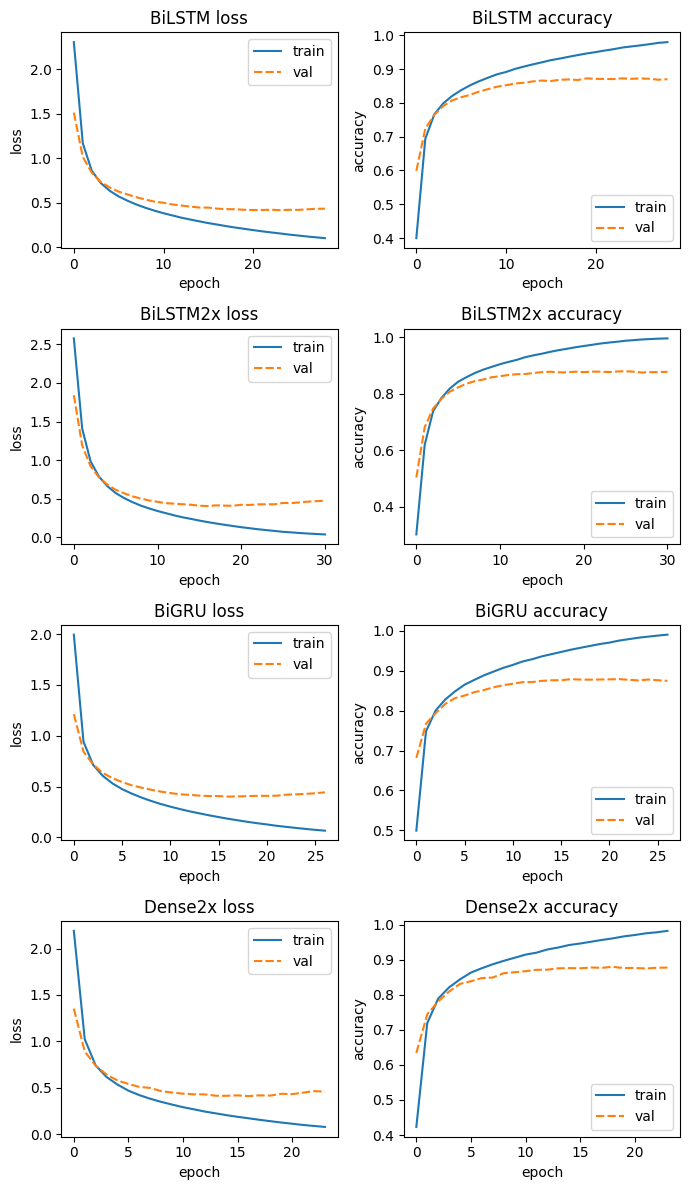

In [68]:
plot_loss_accuracy(histories)

We evaluate the models on the validation set, computing the macro F1 scores and plotting the confusion matrix.

In [69]:
f1_scores = compute_f1(list(models.values()), X_val_pad, y_val_hot, pos_filters_enc)

21/21 [==============================] - 0s 6ms/step


In [70]:
# macro F1 scores obtained by the models on the validation set
for model, f1 in zip(models.values(), f1_scores):
    print(f'{model.name}: {round(f1, 3)}')

BiLSTM: 0.727
BiLSTM2x: 0.735
BiGRU: 0.738
Dense2x: 0.73


21/21 [==============================] - 0s 6ms/step


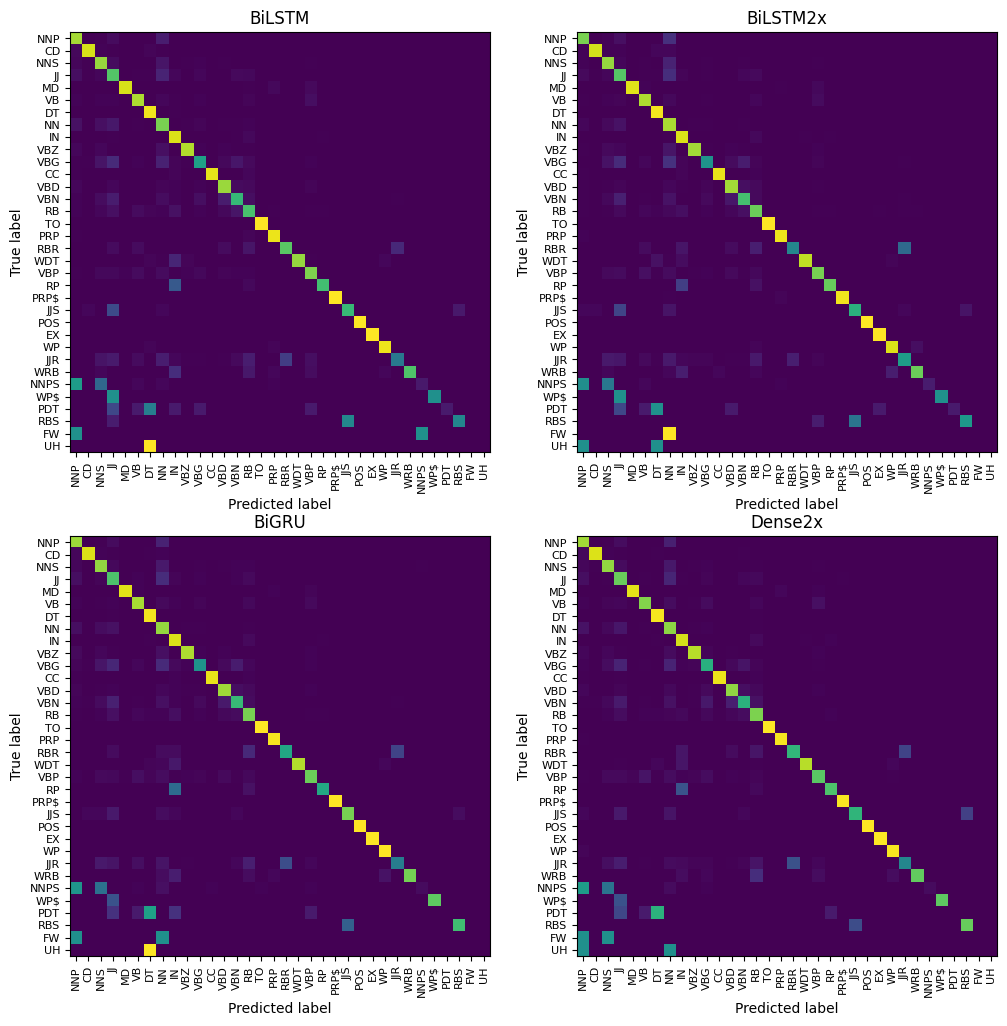

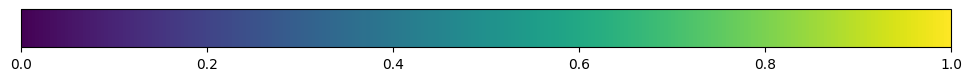

In [71]:
plot_confusion_matrix(list(models.values()), X_val_pad, y_val_hot, pos_filters_enc)

We compare the F1 score of each model and then select the two best performing models

In [72]:
best_models = [list(models.values())[i] for i in np.argsort(f1_scores)[2:]]
print('The best models wrt F1 score (average macro) are: \n\t{}\n\t{}'.format(best_models[0].name, best_models[1].name))

The best models wrt F1 score (average macro) are: 
	BiLSTM2x
	BiGRU


We will now check the results of the two best performing models on the test set, printing the classification report and confusion matrix for each

In [73]:
f1_scores_test = compute_f1(best_models, X_test_pad, y_test_hot, pos_filters_enc)

11/11 [==============================] - 0s 5ms/step


11/11 [==============================] - 0s 7ms/step
The classification report for the model BiLSTM2x is 
               precision    recall  f1-score   support

         NNP       0.90      0.83      0.86      1504
          CD       0.97      0.96      0.97       858
         NNS       0.85      0.87      0.86       941
          JJ       0.71      0.74      0.72       918
          MD       0.96      0.99      0.97       167
          VB       0.90      0.95      0.92       403
          DT       0.98      0.99      0.99      1335
          NN       0.82      0.88      0.85      2383
          IN       0.97      0.94      0.95      1630
         VBZ       0.88      0.88      0.88       280
         VBG       0.63      0.48      0.54       221
          CC       0.99      0.99      0.99       366
         VBD       0.87      0.86      0.87       634
         VBN       0.74      0.68      0.71       366
          RB       0.76      0.78      0.77       381
          TO       1.00     

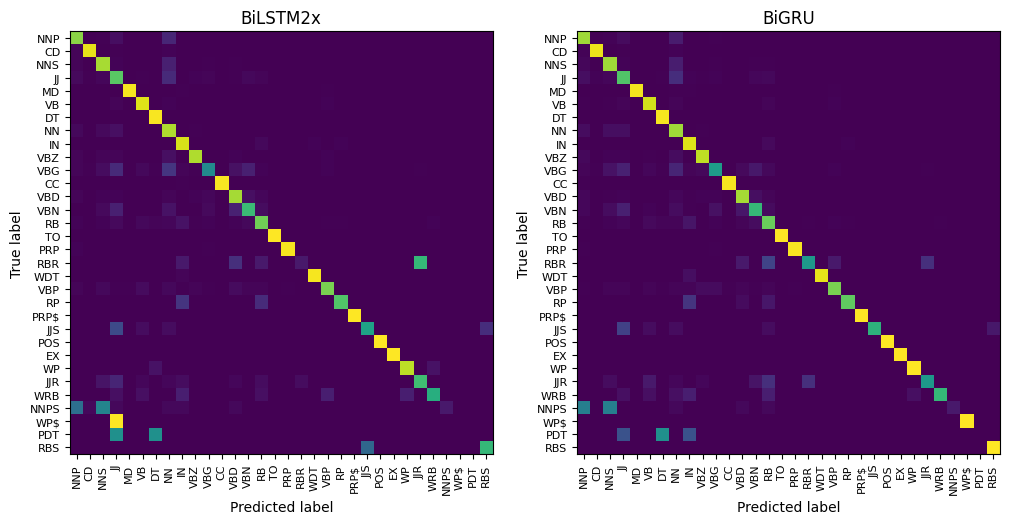

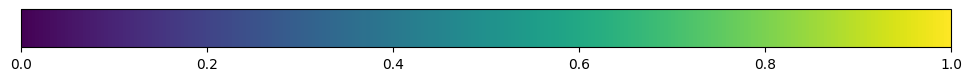

In [74]:
plot_confusion_matrix(best_models, X_test_pad, y_test_hot, pos_filters_enc, print_report=True)

In [75]:
print('The F1 scores of the best models on the test set are:')
print('\n'.join([f'{model.name}: {round(f1, 3)}' for model, f1 in zip(best_models, f1_scores_test)]))

The F1 scores of the best models on the test set are:
BiLSTM2x: 0.742
BiGRU: 0.803


### Final considerations

The final results obtained by the two best models, BiLSTM2x and BiGRU,, in terms of macro F1-score on the test set are 0.742 and 0.803, respectively.

As we can see from the confusion matrix on the validation set, the models have issues on some particular classes, in particular the ones with indexes 35,
39, 41 and 42, corresponding to classes NNPS, PDT, FW and UH, respectively. It is likely that this happens since in the training corpus classes are unevenly
distributed and those labels appear with a very low frequency.